In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
import pickle

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [72]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 100
# BATCH_SIZE = 100
LEARNING_RATE = 0.03
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [73]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)


def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [74]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

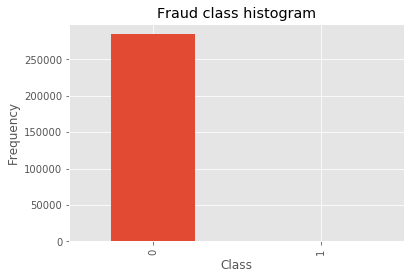

0    284315
1       492
Name: Class, dtype: int64

In [75]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [76]:
# Split dataset on train_and_validation dataset and test dataset
# train_and_validation, test = split_data(dataset, train_size=0.8)


In [77]:
# export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("..", "data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("..", "data", "test_dataset.data"), "wb" ))


In [78]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("..", "data", "train_and_validation_dataset.data"), "rb" ))


In [79]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


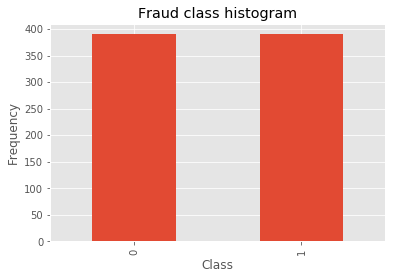

0    390
1    390
Name: Class, dtype: int64

In [80]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [81]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [82]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)
            
        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))


    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        for i in range(self.epochs):
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.cumulative_gradient = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [83]:
# k-fold validation with k=5
k_fold_split_array = k_fold_split_data(under_sample_dataset, N_SPLITS)
models = []
for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = train[:, :-1]
    y_train = train[:, -1:]

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)
    
    print("\n", '='*80)
    print("Validation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)

Loss:  0.386571910578  Accuracy:  0.34615384615384615
Loss:  0.222640133062  Accuracy:  0.594551282051282
Loss:  0.20695976233  Accuracy:  0.6105769230769231
Loss:  0.192535531022  Accuracy:  0.6378205128205128
Loss:  0.179703964731  Accuracy:  0.6698717948717948
Loss:  0.168599946887  Accuracy:  0.7019230769230769
Loss:  0.159173338783  Accuracy:  0.7243589743589743
Loss:  0.151241750772  Accuracy:  0.7419871794871795
Loss:  0.144545939799  Accuracy:  0.7660256410256411
Loss:  0.138814437552  Accuracy:  0.7932692307692307
Loss:  0.133818471102  Accuracy:  0.8076923076923077
Loss:  0.12938871889  Accuracy:  0.8189102564102564
Loss:  0.125407631651  Accuracy:  0.8285256410256411
Loss:  0.121796775656  Accuracy:  0.8365384615384616
Loss:  0.118503079444  Accuracy:  0.8461538461538461
Loss:  0.115486938308  Accuracy:  0.8589743589743589
Loss:  0.112716168464  Accuracy:  0.8621794871794872
Loss:  0.110163430657  Accuracy:  0.8766025641025641
Loss:  0.107805193089  Accuracy:  0.876602564102

Loss:  0.0751787489675  Accuracy:  0.9391025641025641
Loss:  0.0747764284217  Accuracy:  0.9375
Loss:  0.0743897909444  Accuracy:  0.9375
Loss:  0.0740180472159  Accuracy:  0.9375
Loss:  0.0736604612218  Accuracy:  0.9391025641025641
Loss:  0.0733163466914  Accuracy:  0.9407051282051282
Loss:  0.0729850676902  Accuracy:  0.9407051282051282
Loss:  0.0726660197711  Accuracy:  0.9407051282051282
Loss:  0.0723586436268  Accuracy:  0.9423076923076923
Loss:  0.072062413938  Accuracy:  0.9423076923076923
Loss:  0.0717768345945  Accuracy:  0.9423076923076923
Loss:  0.0715014433269  Accuracy:  0.9423076923076923
Loss:  0.0712358004445  Accuracy:  0.9423076923076923
Loss:  0.0709795020028  Accuracy:  0.9423076923076923
Loss:  0.0707321647074  Accuracy:  0.9423076923076923
Loss:  0.0704934248101  Accuracy:  0.9407051282051282
Loss:  0.0702629414865  Accuracy:  0.9407051282051282
Loss:  0.0700403916088  Accuracy:  0.9407051282051282
Loss:  0.0698254678745  Accuracy:  0.9407051282051282
Loss:  0.06

Loss:  0.183953225503  Accuracy:  0.6810897435897436
Loss:  0.16928047584  Accuracy:  0.7003205128205128
Loss:  0.157849856992  Accuracy:  0.7259615384615384
Loss:  0.14883881622  Accuracy:  0.7660256410256411
Loss:  0.141038632475  Accuracy:  0.7852564102564102
Loss:  0.134251863407  Accuracy:  0.7980769230769231
Loss:  0.128345711907  Accuracy:  0.8221153846153846
Loss:  0.123177713216  Accuracy:  0.842948717948718
Loss:  0.118621934813  Accuracy:  0.8557692307692307
Loss:  0.114576753775  Accuracy:  0.8605769230769231
Loss:  0.110962022877  Accuracy:  0.8701923076923077
Loss:  0.107714525555  Accuracy:  0.8798076923076923
Loss:  0.104783970885  Accuracy:  0.8798076923076923
Loss:  0.102129881201  Accuracy:  0.8878205128205128
Loss:  0.0997192804456  Accuracy:  0.8878205128205128
Loss:  0.0975247127266  Accuracy:  0.8942307692307693
Loss:  0.0955228256672  Accuracy:  0.8990384615384616
Loss:  0.0936932638425  Accuracy:  0.9086538461538461
Loss:  0.0920179661519  Accuracy:  0.91346153

Loss:  0.0738631645417  Accuracy:  0.9246794871794872
Loss:  0.0736155197464  Accuracy:  0.9246794871794872
Loss:  0.0733766861805  Accuracy:  0.9246794871794872
Loss:  0.0731462988754  Accuracy:  0.9246794871794872
Loss:  0.0729240149655  Accuracy:  0.9246794871794872
Loss:  0.072709519357  Accuracy:  0.9262820512820513
Loss:  0.0725025098419  Accuracy:  0.9262820512820513
Loss:  0.072302703252  Accuracy:  0.9262820512820513
Loss:  0.0721098335593  Accuracy:  0.9262820512820513
Loss:  0.0719236471611  Accuracy:  0.9262820512820513
Loss:  0.0717439069597  Accuracy:  0.9262820512820513
Loss:  0.071570387648  Accuracy:  0.9278846153846154
Loss:  0.0714028778632  Accuracy:  0.9278846153846154
Loss:  0.071241167808  Accuracy:  0.9278846153846154
Loss:  0.0710850683086  Accuracy:  0.9278846153846154
Loss:  0.0709343946793  Accuracy:  0.9278846153846154
Loss:  0.0707889722266  Accuracy:  0.9278846153846154
Loss:  0.0706486346098  Accuracy:  0.9278846153846154
Loss:  0.0705132245666  Accuracy

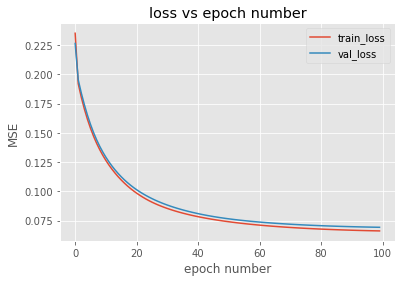

In [84]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [85]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:
Loss:  0.529388955994  Accuracy:  0.35128205128205126
Loss:  0.509245726641  Accuracy:  0.3564102564102564
Loss:  0.42339446512  Accuracy:  0.38333333333333336
Loss:  0.200370494492  Accuracy:  0.6448717948717949
Loss:  0.189659273703  Accuracy:  0.6602564102564102
Loss:  0.180592669817  Accuracy:  0.6807692307692308
Loss:  0.172293068146  Accuracy:  0.7025641025641025
Loss:  0.164633715528  Accuracy:  0.7384615384615385
Loss:  0.157562188424  Accuracy:  0.7589743589743589
Loss:  0.15103269635  Accuracy:  0.782051282051282
Loss:  0.144998375248  Accuracy:  0.7987179487179488
Loss:  0.139414300054  Accuracy:  0.8102564102564103
Loss:  0.134241403881  Accuracy:  0.8243589743589743
Loss:  0.129449890748  Accuracy:  0.8346153846153846
Loss:  0.125022177455  Accuracy:  0.8512820512820513
Loss:  0.120951573856  Accuracy:  0.8564102564102564
Loss:  0.117233316915  Accuracy:  0.8641025641025641
Loss:  0.11385357494  Accuracy:  0.8717948717948718
Loss:  0.110785444572 

In [86]:
test = pickle.load(open(os.path.join("..", "data", "test_dataset.data"), "rb" ))
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss:  0.0677769789441
Accuracy:  0.9838839928373302

Precision: 0.062
Recall: 0.9117647058823529
F-score: 0.11610486891385768


             actual 1  actual 0
predicted 1        93      1407
predicted 0         9     55453


100%|██████████| 21/21 [01:19<00:00,  3.80s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


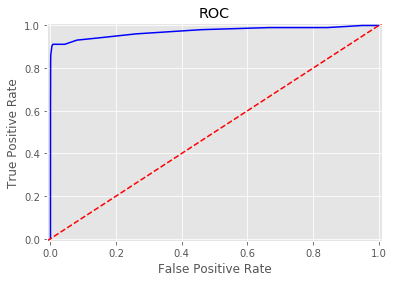

In [87]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)